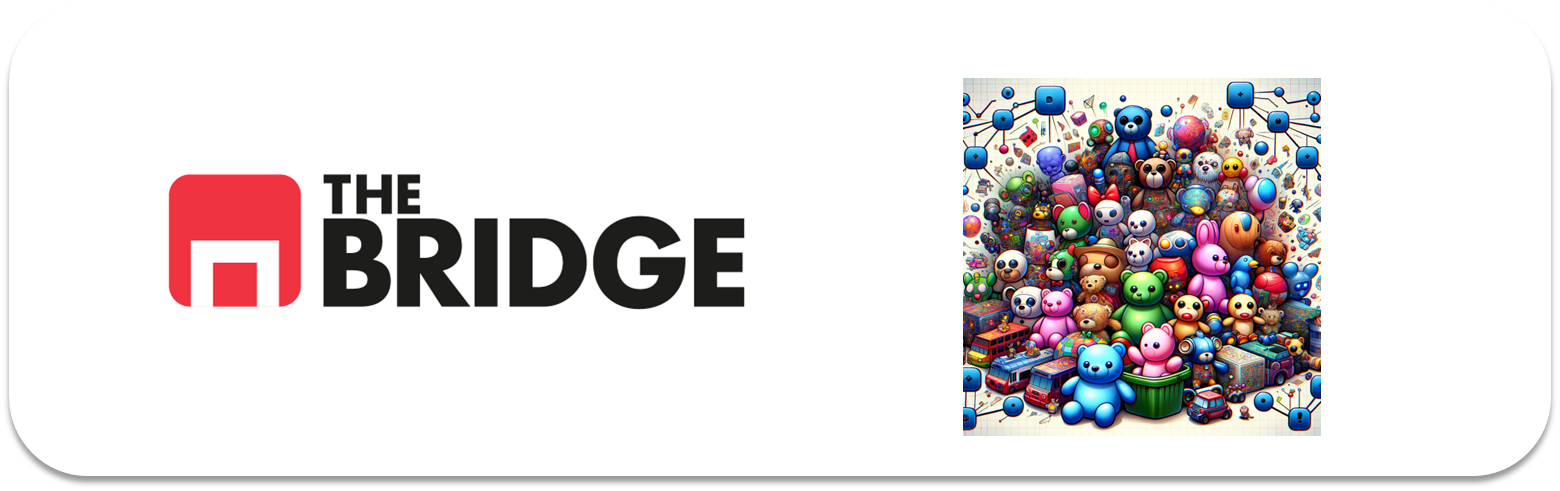

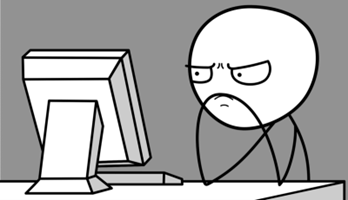

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


- Empezamos obteniendo informacion sobre los datos. Se ven datos negativos, que quieren decir?

In [11]:
df = pd.read_csv('./data/empowering_drinks.csv', sep = '|')
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [13]:
df.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


- Veamos sus cardinalidades

In [14]:
for x in df.columns:
    print(x, '-->', df[x].nunique()/len(df)*100)

Azúcares --> 72.54901960784314
Vitamínas del grupo B --> 49.01960784313725
Cafeína --> 79.08496732026144
Ácido Cítrico --> 73.20261437908496
Taurina --> 77.77777777777779


- Veamos su distribución. No tienen mala apariencia, salvo por los valores negativos de -2, -3

array([[<Axes: title={'center': 'Azúcares'}>,
        <Axes: title={'center': 'Vitamínas del grupo B'}>],
       [<Axes: title={'center': 'Cafeína'}>,
        <Axes: title={'center': 'Ácido Cítrico'}>],
       [<Axes: title={'center': 'Taurina'}>, <Axes: >]], dtype=object)

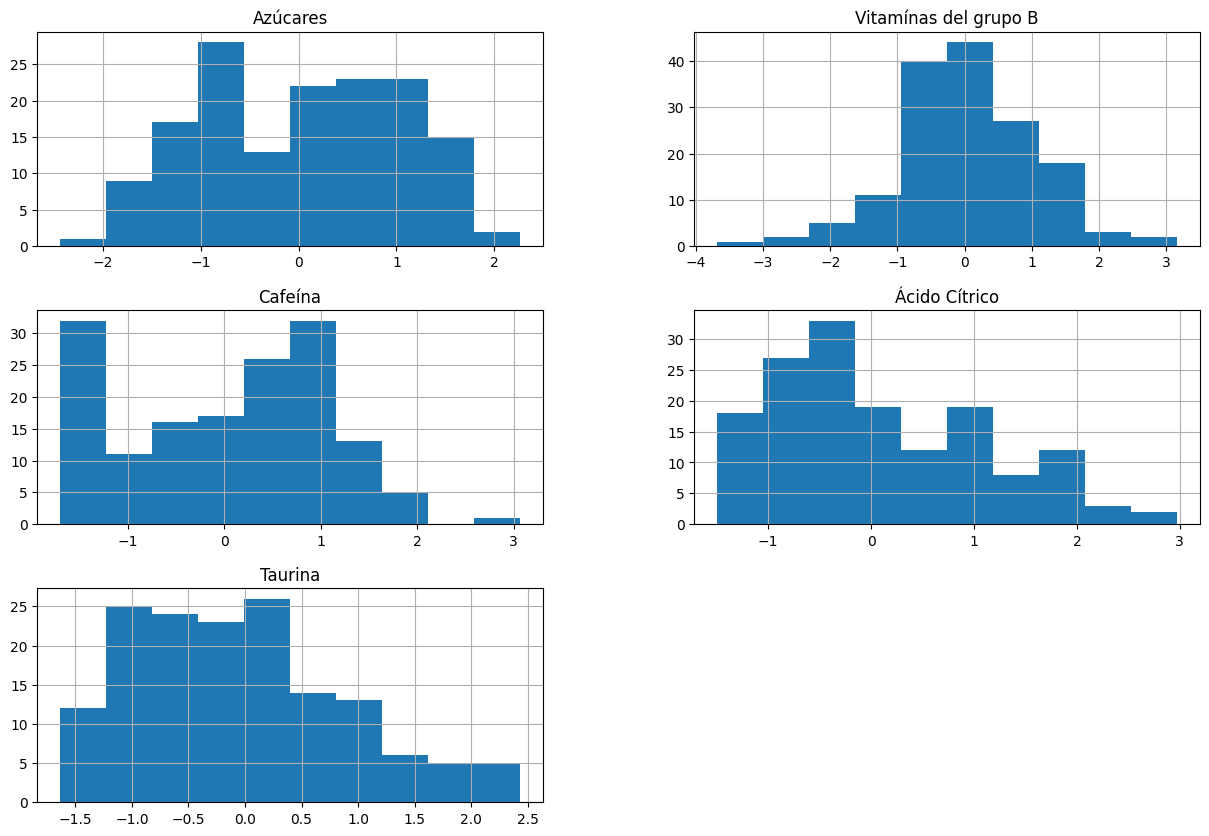

In [15]:
df.hist(figsize=(15,10))

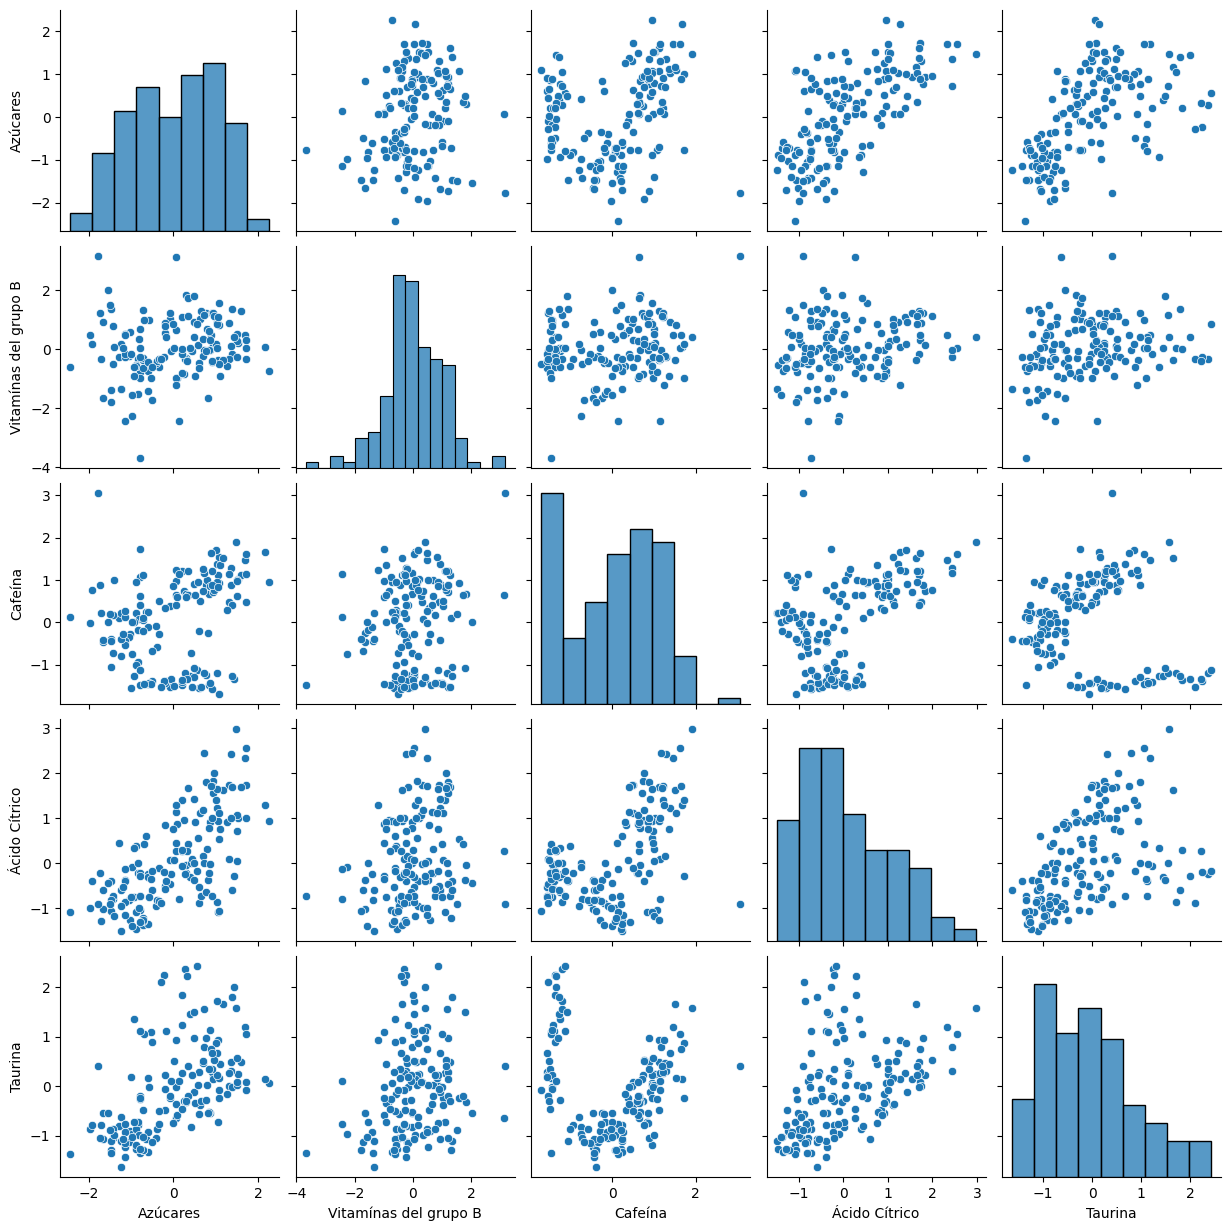

In [16]:
sns.pairplot(df)

In [17]:
df_scal = df.copy()

- Extraer combinaciones pares

In [18]:
#for valores in combinations(train_set.columns, r = 2): # itertools
    #print(valores)

In [19]:
#for x, y in combinations(train_set.columns, r = 2):
    #print(f"{x} vs {y}")
    #bt.grafico_dispersion_con_correlacion(train_set, x, y, mostrar_correlacion= True)

- He probado a transformar algunas features para obtener curvas mas normales pero no he obtenido mejoras asique paso directamente al escalado. Como hay datos negativos y positivos, vamos a escalar entre -1 y 1.

In [20]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler(feature_range=(-1,1))
df_scal = pd.DataFrame(min_max.fit_transform(df_scal))
df_scal

,0,1,2,3,4
0,0.684211,0.144385,0.147679,0.122682,-0.072340
1,0.142105,-0.165775,0.021097,0.101284,-0.340426
2,0.121053,0.401070,0.223629,0.293866,-0.063830
3,0.757895,0.219251,0.329114,0.714693,0.387234
4,0.163158,0.614973,-0.008439,-0.348074,-0.353191
...,...,...,...,...,...
148,0.247368,0.197861,-0.827004,-0.326676,0.280851
149,0.178947,-0.037433,-0.852321,-0.205421,0.897872
150,0.126316,0.080214,-0.856540,-0.198288,0.706383
151,0.631579,0.475936,-0.822785,-0.597718,0.685106


In [21]:
df_scal.describe()

,0,1,2,3,4
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.045361,0.087394,-0.269973,-0.295261,-0.217836
std,0.437231,0.291416,0.437475,0.452196,0.459598
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.310526,-0.069519,-0.725738,-0.661912,-0.589362
50%,0.063158,0.069519,-0.198312,-0.405136,-0.272340
75%,0.410526,0.283422,0.088608,0.079886,0.046809
max,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

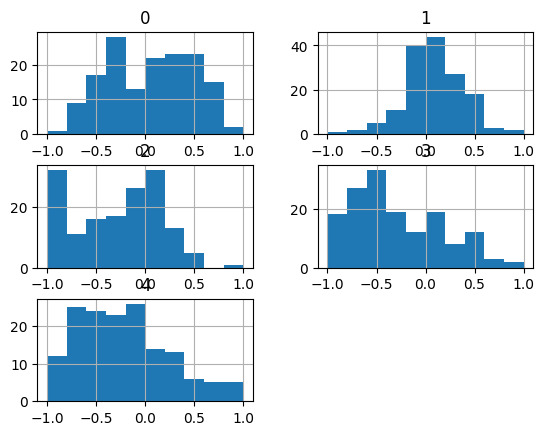

In [22]:
df_scal.hist()

- Obtengo el valor de eps según el porcentaje de anomalías comentado en clase sea menor a 10%

In [23]:
from sklearn.cluster import DBSCAN
outlier_percent = []

for eps in np.linspace(0.001,3,50): # Genera 50 valores equidistantes entre 0.001 y 3
    
    # Creamos el modelo
    dbscan = DBSCAN(eps=eps,min_samples=2*df_scal.shape[1]) # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
    dbscan.fit(df_scal)
   
     
    # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

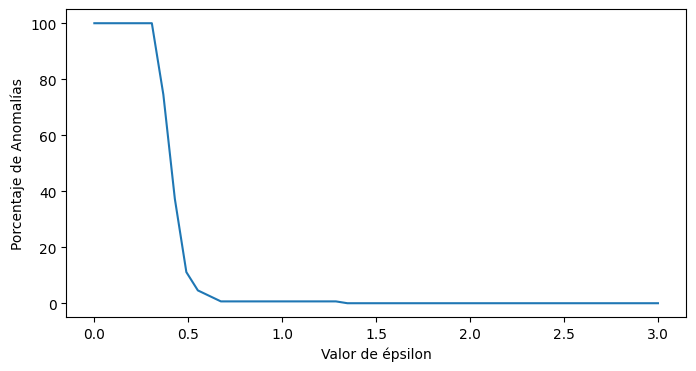

In [24]:
#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

In [25]:
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,3,50)) if 0.2 <= val <= 0.8]:
    print(f"Para {eps}: {outlier_percent[indice]}% de anomalías")

Para 0.24581632653061225: 100.0% de anomalías
Para 0.3070204081632653: 100.0% de anomalías
Para 0.3682244897959184: 74.50980392156863% de anomalías
Para 0.42942857142857144: 37.254901960784316% de anomalías
Para 0.4906326530612245: 11.11111111111111% de anomalías
Para 0.5518367346938776: 4.57516339869281% de anomalías
Para 0.6130408163265306: 2.6143790849673203% de anomalías
Para 0.6742448979591836: 0.6535947712418301% de anomalías
Para 0.7354489795918367: 0.6535947712418301% de anomalías
Para 0.7966530612244899: 0.6535947712418301% de anomalías


- Entreno el modelo para eps = 0.5. Min_samples es igual al doble del numero de las features

In [26]:
dbscan= DBSCAN(eps = 0.5, min_samples= 2*len(df_scal.columns.to_list()))
dbscan.fit(df_scal)
dbscan.min_samples

10

- El modelo nos ha generado tres clusters y uno de anomalias

In [27]:
print(np.unique(dbscan.labels_))

[-1  0  1  2]


In [28]:
df['cluster'] = dbscan.labels_
df['cluster'].value_counts()

cluster
 0    54
 1    52
 2    34
-1    13
Name: count, dtype: int64

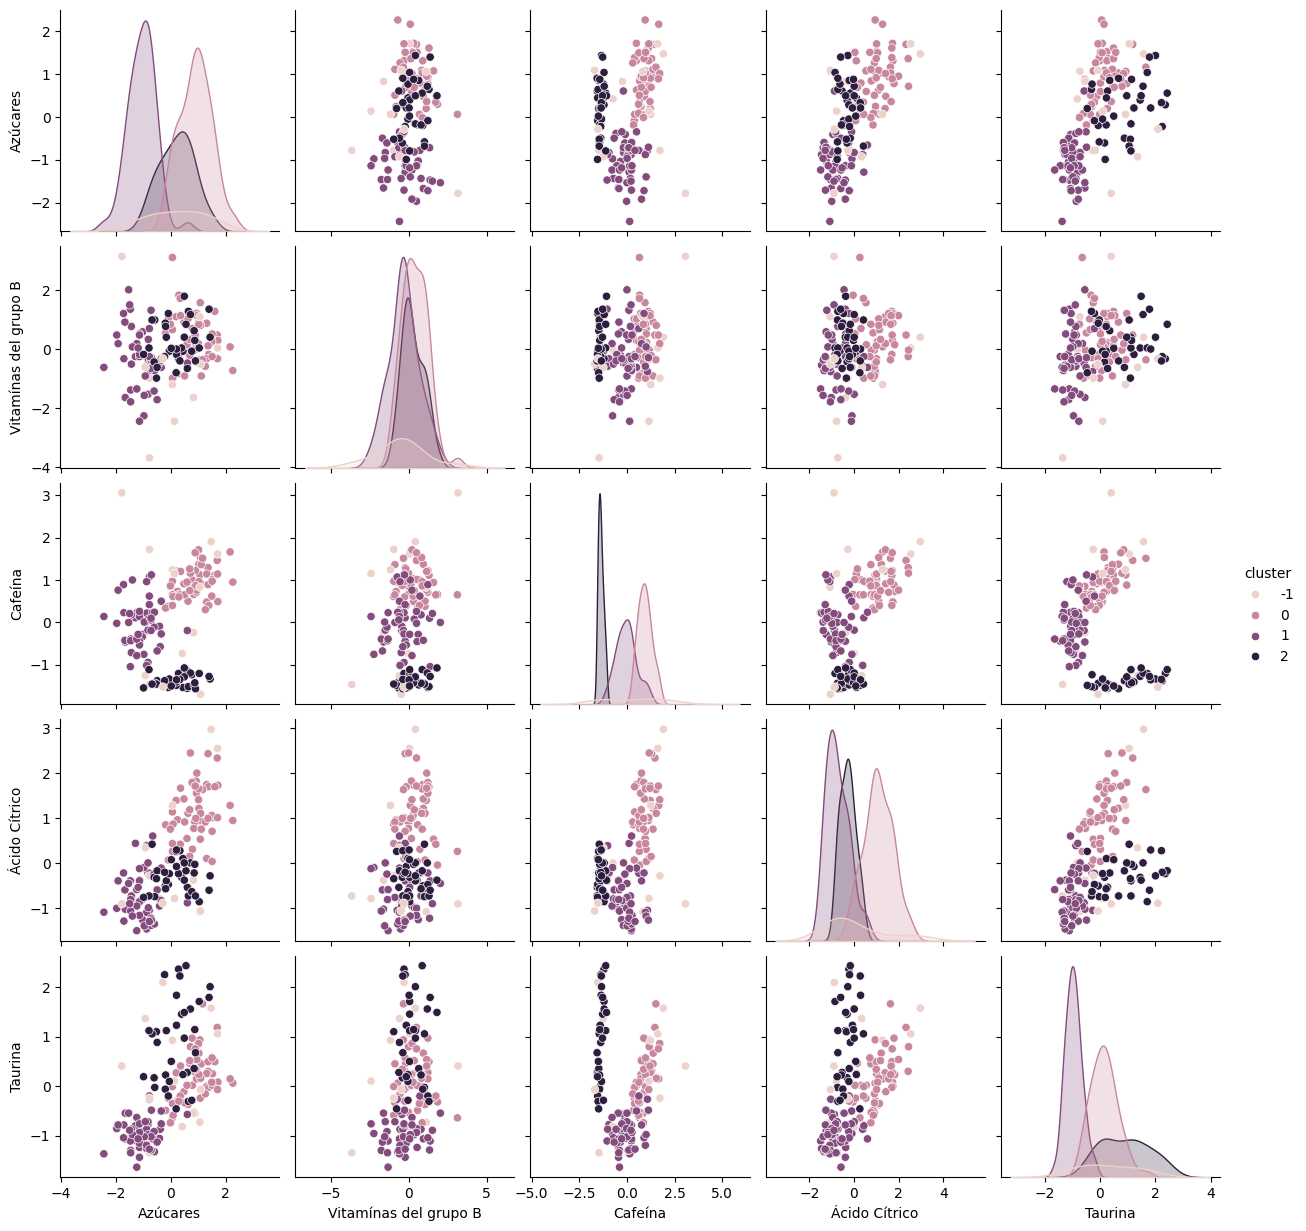

In [29]:
sns.pairplot(df, hue = 'cluster')

<Axes: xlabel='Cafeína', ylabel='Taurina'>

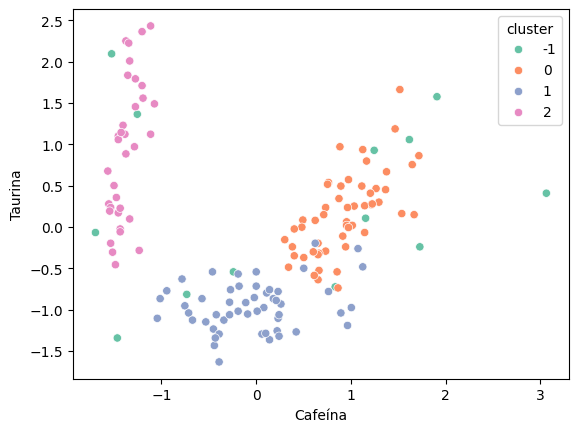

In [30]:
sns.scatterplot(data = df[["Cafeína","Taurina","cluster"]], x= "Cafeína", y = "Taurina", 
                hue = "cluster", palette="Set2")

In [54]:
features = [col for col in df.columns if col != 'cluster']
features

['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

In [56]:
features_mean_by_cluster = df[features + ['cluster']].groupby('cluster').mean()
features_mean_by_cluster['Freq'] = df['cluster'].value_counts().sort_index()

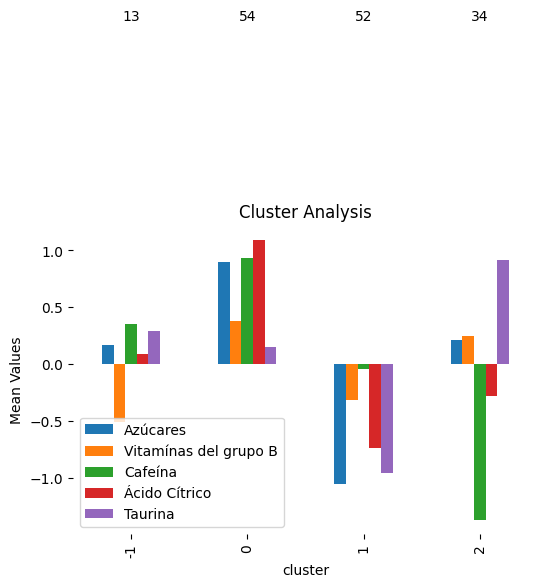

In [62]:
fig, ax = plt.subplots(figsize=(6, 4))
features_mean_by_cluster.iloc[:, :-1].plot(kind='bar', ax=ax)
ax.set_ylabel('Mean Values')
ax.set_title('Cluster Analysis')
for i, v in enumerate(features_mean_by_cluster['Freq']):
    ax.text(i, max(features_mean_by_cluster.iloc[:, :-1].max().max(), 2) + 1, str(v), ha='center', va='bottom')
sns.despine(left=True, bottom=True)
plt.show()

In [76]:
valores = df.groupby('cluster')[features].mean()
valores

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
cluster,,,,,
-1,0.170273,-0.510263,0.356755,0.084362,0.291314
0,0.898464,0.378266,0.934050,1.092326,0.150303
1,-1.059053,-0.318357,-0.040584,-0.735217,-0.957316
2,0.214189,0.248955,-1.373071,-0.282580,0.915635


- Se podria eliminar la feature Vitamina B que parece que agrupa mucho los datos y confunde al modelo. Vamos a probarlo.

In [80]:
df_scal_2 = df_scal.copy()
df_scal_2 = df_scal_2.drop(1, axis = 1)

In [82]:
from sklearn.cluster import DBSCAN
outlier_percent = []

for eps in np.linspace(0.001,3,50): # Genera 50 valores equidistantes entre 0.001 y 3
    
    # Creamos el modelo
    dbscan = DBSCAN(eps=eps,min_samples=2*df_scal_2.shape[1]) # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
    dbscan.fit(df_scal_2)
   
     
    # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

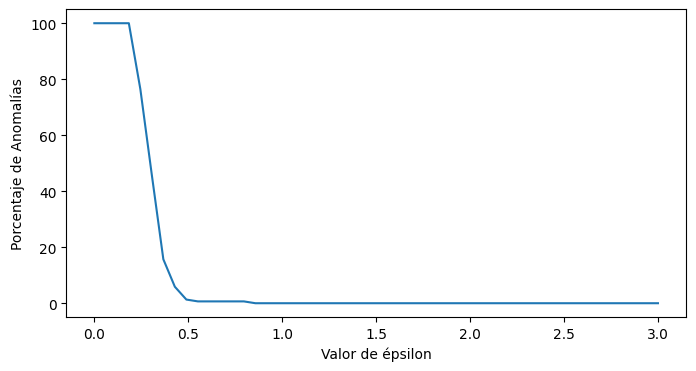

In [83]:
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

In [84]:
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,3,50)) if 0.2 <= val <= 0.8]:
    print(f"Para {eps}: {outlier_percent[indice]}% de anomalías")

Para 0.24581632653061225: 76.47058823529412% de anomalías
Para 0.3070204081632653: 45.751633986928105% de anomalías
Para 0.3682244897959184: 15.686274509803921% de anomalías
Para 0.42942857142857144: 5.882352941176471% de anomalías
Para 0.4906326530612245: 1.3071895424836601% de anomalías
Para 0.5518367346938776: 0.6535947712418301% de anomalías
Para 0.6130408163265306: 0.6535947712418301% de anomalías
Para 0.6742448979591836: 0.6535947712418301% de anomalías
Para 0.7354489795918367: 0.6535947712418301% de anomalías
Para 0.7966530612244899: 0.6535947712418301% de anomalías


In [85]:
dbscan_2= DBSCAN(eps = 0.4, min_samples= 2*len(df_scal.columns.to_list()))
dbscan_2.fit(df_scal_2)
dbscan_2.labels_

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,
        0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2, -1,  2,  2,
        2,  2,  2,  2, -1, -1,  2,  2,  2, -1, -1,  2,  2, -1,  2, -1,  2])

In [86]:
np.unique(dbscan_2.labels_)

array([-1,  0,  1,  2])

In [ ]:
df_2 = df.copy()
df_2 = df_2.drop(columns =['Vitamínas del grupo B', 'cluster'])

In [92]:
df_2['cluster'] = dbscan_2.labels_

In [93]:
df_2

,Azúcares,Cafeína,Ácido Cítrico,Taurina,cluster
0,1.518613,1.034819,1.013009,0.251717,0
1,0.246290,0.733629,0.965242,-0.293321,0
2,0.196879,1.215533,1.395148,0.269020,0
3,1.691550,1.466525,2.334574,1.186068,-1
4,0.295700,0.663351,-0.037874,-0.319276,0
...,...,...,...,...,...
148,0.493343,-1.284344,0.009893,0.969783,2
149,0.332758,-1.344582,0.280575,2.224236,-1
150,0.209232,-1.354622,0.296498,1.834923,2
151,1.395086,-1.274305,-0.595160,1.791666,-1


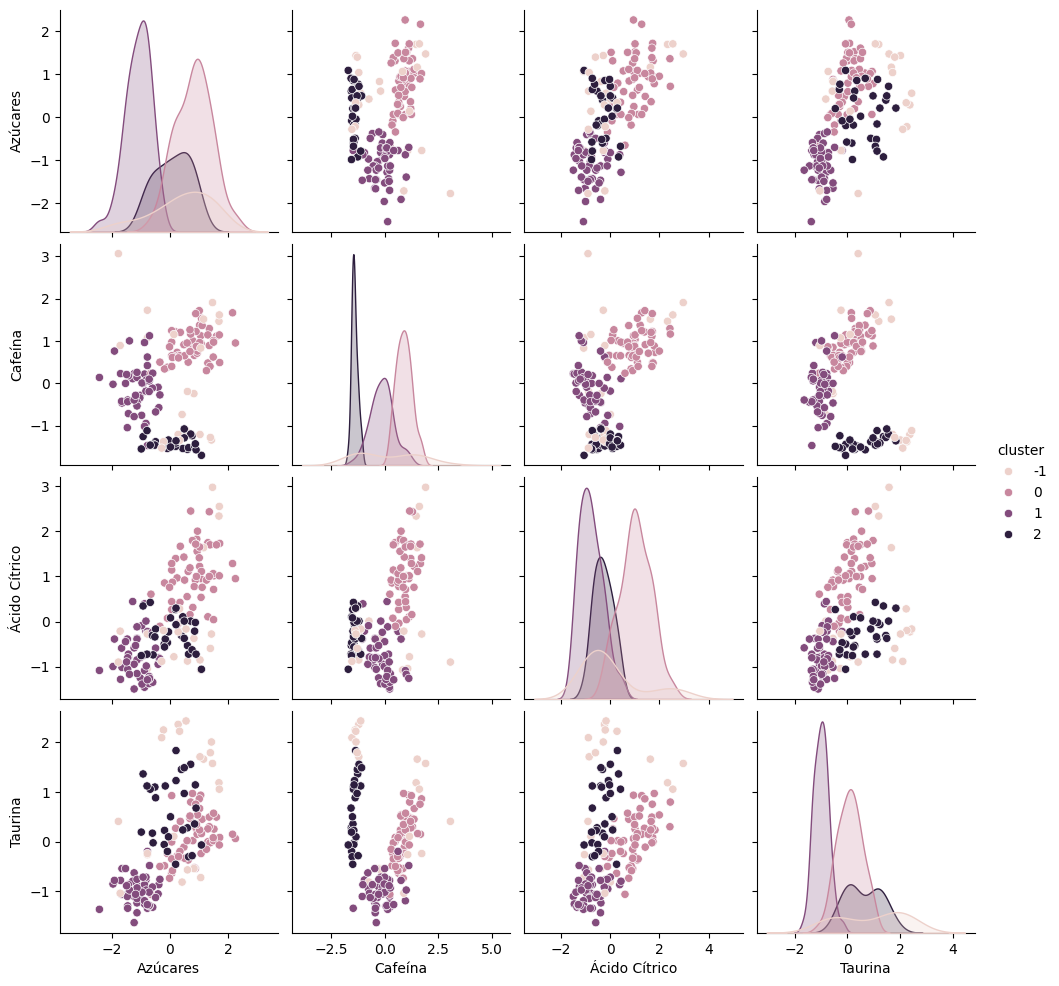

In [95]:
sns.pairplot(df_2, hue = 'cluster')

In [99]:
comparacion = pd.DataFrame({'feat_5':df['cluster'], 'feat_4': df_2.cluster})
print(comparacion.feat_5.value_counts())
print(comparacion.feat_4.value_counts())

feat_5
 0    54
 1    52
 2    34
-1    13
Name: count, dtype: int64
feat_4
 0    55
 1    48
 2    29
-1    21
Name: count, dtype: int64


### Empezamos con el clustering jerarquico

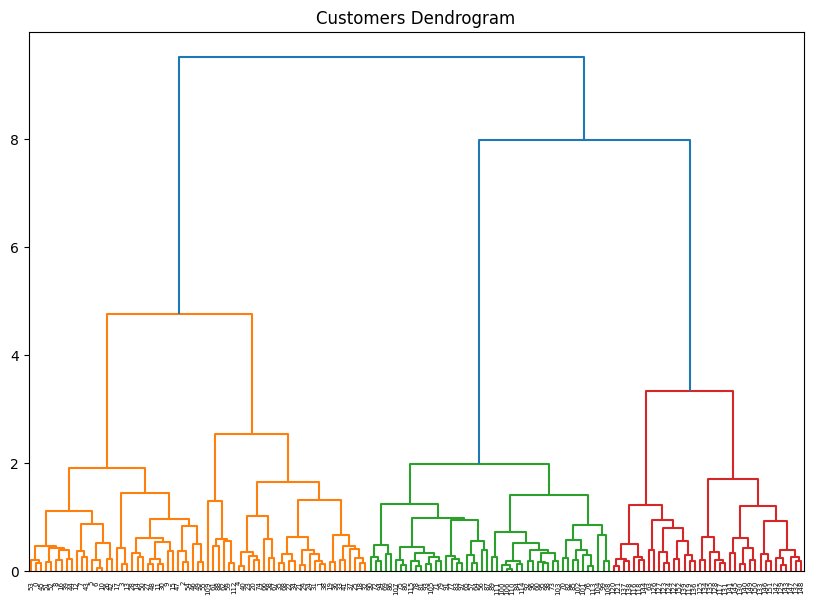

In [100]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

clusters = shc.linkage(df_scal_2, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()


In [101]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(df_scal_2)
clustering_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [107]:
df_jerar = df.copy()
df_jerar = df_jerar.drop(columns = ['Vitamínas del grupo B', 'cluster'])

In [108]:
df_jerar['cluster'] = clustering_model.labels_

In [109]:
feat = [col for col in df_jerar if col != 'cluster']

In [111]:
features_mean_by_cluster = df_jerar[feat + ["cluster"]].groupby('cluster').mean()
features_mean_by_cluster['Freq'] = df_jerar['cluster'].value_counts().sort_index()

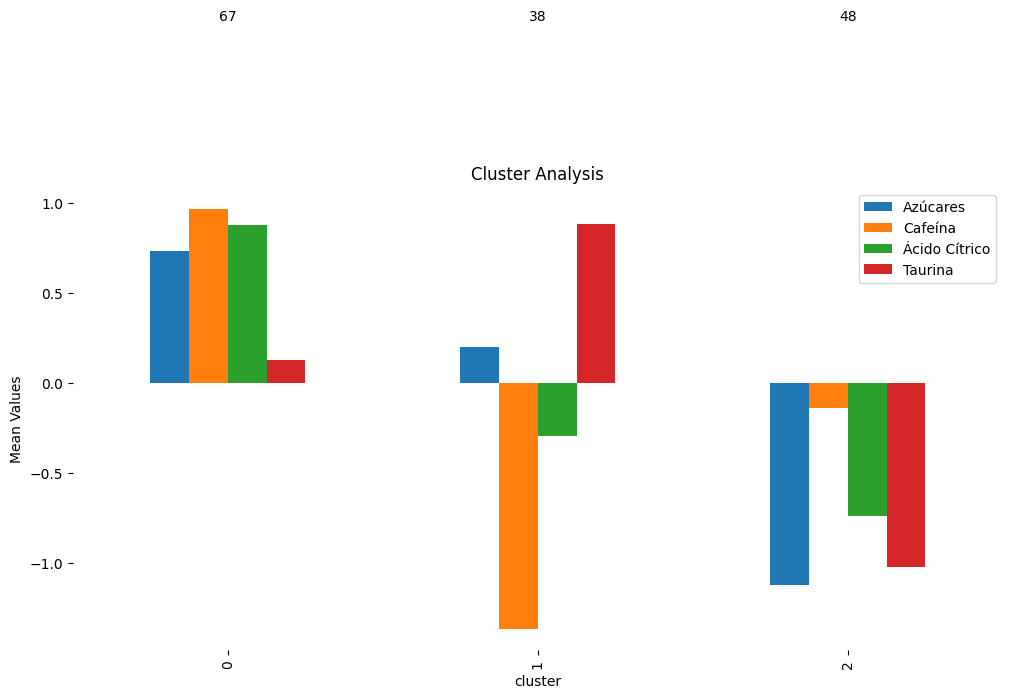

In [114]:
# Perfil de cada cluster
fig, ax = plt.subplots(figsize=(12, 6))
features_mean_by_cluster.iloc[:, :-1].plot(kind='bar', ax=ax)
ax.set_ylabel('Mean Values')
ax.set_title('Cluster Analysis')
for i, v in enumerate(features_mean_by_cluster['Freq']):
    ax.text(i, max(features_mean_by_cluster.iloc[:, :-1].max().max(), 1) + 1, str(v), ha='center', va='bottom')
sns.despine(left=True, bottom=True)
plt.show()

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.